### Checklist for submission

It is extremely important to make sure that:

1. Everything runs as expected (no bugs when running cells);
2. The output from each cell corresponds to its code (don't change any cell's contents without rerunning it afterwards);
3. All outputs are present (don't delete any of the outputs);
4. Fill in all the places that say `# YOUR CODE HERE`, or "**Your answer:** (fill in here)".
5. Never copy/paste any notebook cells. Inserting new cells is allowed, but it should not be necessary.
6. The notebook contains some hidden metadata which is important during our grading process. **Make sure not to corrupt any of this metadata!** The metadata may for example be corrupted if you copy/paste any notebook cells, or if you perform an unsuccessful git merge / git pull. It may also be pruned completely if using Google Colab, so watch out for this. Searching for "nbgrader" when opening the notebook in a text editor should take you to the important metadata entries.
7. Although we will try our very best to avoid this, it may happen that bugs are found after an assignment is released, and that we will push an updated version of the assignment to GitHub. If this happens, it is important that you update to the new version, while making sure the notebook metadata is properly updated as well. The safest way to make sure nothing gets messed up is to start from scratch on a clean updated version of the notebook, copy/pasting your code from the cells of the previous version into the cells of the new version.
8. If you need to have multiple parallel versions of this notebook, make sure not to move them to another directory.
9. Although not forced to work exclusively in the course Docker environment, you need to make sure that the notebook will run in that environment, i.e. that you have not added any additional dependencies.

Failing to meet any of these requirements might lead to either a subtraction of POEs (at best) or a request for resubmission (at worst).

We advise you the following steps before submission for ensuring that requirements 1, 2, and 3 are always met: **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). This might require a bit of time, so plan ahead for this (and possibly use Google Cloud's GPU in HA1 and HA2 for this step). Finally press the "Save and Checkout" button before handing in, to make sure that all your changes are saved to this .ipynb file.

### Fill in name of notebook file
This might seem silly, but the version check below needs to know the filename of the current notebook, which is not trivial to find out programmatically.

You might want to have several parallel versions of the notebook, and it is fine to rename the notebook as long as it stays in the same directory. **However**, if you do rename it, you also need to update its own filename below:

In [2]:
nb_fname = "HA1.ipynb"

### Fill in group number and member names:

In [2]:
GROUP = "34"
NAME1 = "Johan Martinsson"
NAME2 = "Sanjiv Thottathodhi"

### Check Python version

In [3]:
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','7'), "You are not running Python 3.7. Make sure to run Python through the course Docker environment, or alternatively in the provided Conda environment."

### Check that notebook server has access to all required resources, and that notebook has not moved

In [4]:
import os
nb_dirname = os.path.abspath('')
assert nb_dirname != '/workspace', \
    '[ERROR] The notebook server appears to have been started via Docker, at the same directory as the assignment. Make sure to start it at least one level above the assignment.'
assignment_name = os.path.basename(nb_dirname)
assert assignment_name in ['IHA1', 'IHA2', 'HA1', 'HA2', 'HA3'], \
    '[ERROR] The notebook appears to have been moved from its original directory'

### Verify correct nb_fname

In [5]:
from IPython.display import display, HTML
try:
    display(HTML(r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(nb_fname=nb_fname)))
except NameError:
    assert False, 'Make sure to fill in the nb_fname variable above!'

### Verify that your notebook is up-to-date and not corrupted in any way

In [6]:
import sys
sys.path.append('..')
from ha_utils import check_notebook_uptodate_and_not_corrupted
check_notebook_uptodate_and_not_corrupted(nb_dirname, nb_fname)

[SUCCESS] No major notebook mismatch found when comparing to latest GitHub version. (There might be minor updates, but even that is the case, submitting your work based on this notebook version would be acceptable.)


# HA1 - Cats and dogs

<img src="http://lghttp.32478.nexcesscdn.net/80E972/organiclifestylemagazine/wp-content/uploads/2015/10/Cats-and-Dogs.jpg" alt="Cats and dogs" style="width: 5000px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It is comprised of 25k colored images of dogs and cats. Our goal with this dataset will be to create a classifier that can tell us if the input image is of a cat or a dog.

As a way of helping you speed up the training process, each group gets access to an instance in Google Cloud with a K80 GPU. Take a look at the [Instructions folder](https://github.com/JulianoLagana/deep-machine-learning/blob/master/Instructions/03_using_google_cloud.md) to understand how to connect to this instance and use our tools there. You're free to use this limited resource as you see fit, but if you spend all your credits, you'll need a late day to obtain more (and you can only do this once).

In order to make the most out of your GPU hours, first try solving the initial part of this notebook (tasks 0-3) in your own computer (these tasks can be solved only on the CPU), and leave most of the available hours for solving tasks 4-5, and refining your best model further (and, if you have the spare hours, experiment a bit!).

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance.


Hints:
- If you get errors saying you've exhausted the GPU resources, well, then you exhausted the GPU resources. However, sometimes that's because Pytorch didn't release a part of the GPU's memory. If you think your CNN should fit in your memory during training, try restarting the kernel and directly training only that architecture.
- Every group has enough credits on google cloud to complete this assignment. However, this statement assumes you'll use your resources judiciously (e.g. always try the code first in your machine and make sure everything works properly before starting your instances) and **won't forget to stop your instance after using it,**  otherwise you might run out of credits.
- Before starting, take a look at the images we'll be using. This is a hard task, don't get discouraged if your first models perform poorly (several participants in the original competition didn't achieve an accuracy higher than 60%).
- Solving the [computer labs](https://github.com/JulianoLagana/deep-machine-learning/tree/master/computer-labs) is a good way to get prepared for this assignment.

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [2]:
import os

import matplotlib.pyplot as plt

import torch, torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
import torch.nn.functional as F
import matplotlib.ticker as ticker

from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

---
## 1. Loading the data and preprocessing

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats) and download the data from there. You should download both the test and train folders together in one zip file (by clicking the download all button). The split ratio between training and validation has not been made, you'll need to do it yourself. The `test.zip` file contains unlabeled data, so that participants in the contest are not able to train on this set.

Downloading the data to the Google Cloud instance can be a bit tricky. There are a few ways to do it:

 - Using `scp` with the `gcloud` CLI. Download the `dogs-vs-cats.zip` to your local computer and then copy it from there to your cloud instance with the command:
 ```
 # Note: This assumes you named your VM instance (gpu-instance)
 gcloud compute scp  <path_to_local_file>/dogs-vs-cats.zip dml-host@gpu-instance:~/deep-machine-learning/home-assignments/HA1/
 ```
 `scp` uses the same credentials as `ssh`, which `gcloud` handles for you. The first time you `ssh` directly into `dml-host` you have to set a password for your `ssh` keys
 - Using the Kaggle CLI. We have it installed in the docker image, and you can read about it [here](https://github.com/Kaggle/kaggle-api) 

For this assignment you should use [data generators](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) to load the images to your CPU/GPU memory. Because of this, your folder structure for the data should conform to the folder structure expected by the data generators (i.e. the samples should be separated into one folder for each class). Furthermore, we ask you to first start with a smaller subset of the data (1/5 of the number of samples), in order to test different models faster.

This means that you should create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      Cats        Dogs       Cats        Dogs       Cats        Dogs       Cats        Dogs

The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`. We provide you a notebook that shows how to achieve this (`create_project_notebook_structure.ipynb`), starting from the original `dogs-vs-cats.zip` file that you download from Kaggle. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

We advise you to use 30% of the data as validation data in the smaller dataset. However, for the larger dataset, you should decide how to split between training and validation. Please specify your splits in the following cells.

For the larger subset, what was the training/validation split that you decided to use?

**% Samples in the training set:**

**Your answer:** 8750 cats and 8750 dogs

**% Samples in the validation set:**

**Your answer:** 3750 cats and 3750 dogs

**Optional (1 POE):** Would you keep the same ratio split between train and validation sets if you had a large dataset compared to if you had a smaller one?


**Your answer:** No, if we have a very large dataset, there's a good reason to change the split into having a larger amount of training data than validation since we don't require a large amount of validation data to tell us that the CNN is working fine. One way to go is to start with 80/20 and then change the ratio to test the new performance.

Fill in the dataset paths (to be used later by your data generators):

In [3]:
# TODO: Change the directories accordingly
cwd = os.getcwd()

train_path = '/workspace/home-assignments/HA1/train'
val_path = '/workspace/home-assignments/HA1/val'
small_train_path = '/workspace/home-assignments/HA1/small_train'
small_val_path = '/workspace/home-assignments/HA1/small_val'

---
### 1.1 Preprocessing
**(2 POE)** 

Once you have the expected folder structure, create two data generators for automatically generating batches from the images in your smaller subset of data. Don't use any [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/), but feel free to preprocess the data as you see fit. 

Hints:
- Take a look at [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) and [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) from the pytorch docs.
- To preprocess the data you can use the built-in pytorch [Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The specified `batch_size` should be chosen so that you don't run out of memory.
- The `DataLoader` constructor takes an optional argument `num_workers`, which defaults to `0` if not provided. Setting a higher number creates multiple threads which load batches concurrently. This can speed up training considerably. However, for multi-threading to work, you need to add `--ipc host` to your `docker run` command.  
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. Resizing the images can be done using the previously mentioned built-in pytorch Transforms.
- Resizing the images to a smaller size while loading them can be beneficial. However, the VGG network that is used later in this assignment requires that images are at least 224x224.

In [4]:
''' Make a compose transform function to be used in ImageFolder, this both resizes and converts to type tensor '''
transformFunc = transforms.Compose([transforms.Resize((50,50)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

small_train = torchvision.datasets.ImageFolder(small_train_path, transform = transformFunc)
small_val = torchvision.datasets.ImageFolder(small_val_path, transform = transformFunc)

small_train_data_loader = DataLoader(small_train, batch_size=64, shuffle=True)
small_val_data_loader = DataLoader(small_val, batch_size=64)

---
## 2. Training

**(1 POE)**

Create your first CNN architecture for this task. Start with something as simple as possible, that you're almost sure can get an accuracy better than 50% (we'll improve upon it later).

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

def evaluate_model(small_val_data_loader, model, loss_fn):
    losses = []
    n_correct = 0
    with torch.no_grad():
        for b_x, b_y in small_val_data_loader:            
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()
        val_accuracy = n_correct/len(small_val)
        val_avg_loss = sum(losses)/len(losses)    

    return val_accuracy, val_avg_loss

In [11]:
# YOUR CODE HERE
class CatDogNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(24*24*64, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))        
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1,24*24*64)
        x = self.fc1(x)
        return x

Train your model using the two data generators you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

Hints:
- Note that you will need to plot your training and validation losses and accuracies, so make sure that you saved them during training. 

In [16]:
# The following line automatically figures out what device (cpu or gpu)
# you are using and transfers your model to it 
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

# Any pytorch object (e.g. model, inputs, output, etc.) can 
# be transferred to the current device by running
#       name_of_object.to(device)
# Example:
#       model.to(device)

model = CatDogNetwork()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_accuracy =[]
train_avg_loss=[]
val_acc=[]
val_loss=[]

for epoch in range(10):
    losses = []
    n_correct = 0
    
    for b_x, b_y in small_train_data_loader:
        
        b_x = b_x.to(device)
        b_y = b_y.to(device)               
        # Compute predictions and losses
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        # Count number of correct predictions
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
    # Compute accuracy and loss in the entire training set
    train_accuracy.append((n_correct/len(small_train)))
    train_avg_loss.append((sum(losses)/len(losses)))
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model(small_val_data_loader, model, loss_fn)
    
    val_acc.append((val_accuracy))
    val_loss.append((val_avg_loss))
        
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch+1, train_avg_loss[epoch], val_loss[epoch], train_accuracy[epoch], val_acc[epoch]))

Epoch 1 	Loss: 7.023 	Loss (val): 0.945	Accuracy: 0.58 	Accuracy (val): 0.63
Epoch 2 	Loss: 0.633 	Loss (val): 0.714	Accuracy: 0.71 	Accuracy (val): 0.68
Epoch 3 	Loss: 0.439 	Loss (val): 0.682	Accuracy: 0.80 	Accuracy (val): 0.68
Epoch 4 	Loss: 0.339 	Loss (val): 0.726	Accuracy: 0.85 	Accuracy (val): 0.67
Epoch 5 	Loss: 0.301 	Loss (val): 0.778	Accuracy: 0.88 	Accuracy (val): 0.69
Epoch 6 	Loss: 0.272 	Loss (val): 0.782	Accuracy: 0.89 	Accuracy (val): 0.69
Epoch 7 	Loss: 0.254 	Loss (val): 0.862	Accuracy: 0.89 	Accuracy (val): 0.69
Epoch 8 	Loss: 0.181 	Loss (val): 0.857	Accuracy: 0.93 	Accuracy (val): 0.70
Epoch 9 	Loss: 0.160 	Loss (val): 0.937	Accuracy: 0.94 	Accuracy (val): 0.68
Epoch 10 	Loss: 0.138 	Loss (val): 1.007	Accuracy: 0.95 	Accuracy (val): 0.68


Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

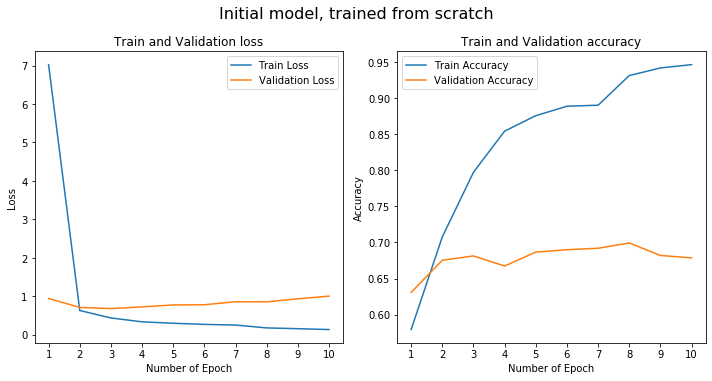

In [48]:
# YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Initial model, trained from scratch', fontsize = 16, y = 1.05)
fig.set_figheight(5)
fig.set_figwidth(10)
number_epoch=[i+1 for i in range(epoch+1)]
ax1.plot(number_epoch, train_avg_loss, label ='Train Loss')
ax1.plot(number_epoch, val_loss, label ='Validation Loss')
# naming the x axis 
ax1.set_xlabel('Number of Epoch') 
# naming the y axis 
ax1.set_ylabel('Loss') 
# giving a title to my graph 
ax1.set_title('Train and Validation loss') 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.legend()
ax2.plot(number_epoch, train_accuracy, label ='Train Accuracy')
ax2.plot(number_epoch, val_acc, label ='Validation Accuracy')
# naming the x axis 
ax2.set_xlabel('Number of Epoch') 
# naming the y axis 
ax2.set_ylabel('Accuracy') 
# giving a title to my graph 
ax2.set_title('Train and Validation accuracy') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend()
fig.tight_layout()

**(2 POE)** Based on these, what would you suggest for improving your model? Why?

**Your answer:** We see a difference between the train and validation accuracy where the validation is notably lower which is a clear sign of overfitting. A possible improvement would be to use regularization and also lower the learning rate. We could also select another architecture for the network which may improve as well. Since we are only using a smaller set of the data, this can also be a reason for the high variance issue.

Another improvement would be to lower the learning rate when the validation accuracy plateaus. This seems to be around 67% for this structure. 

---
## 3. Improving your model

**(1 POE)** Continue to improve your model architecture by comparing the value of the metrics you're interested in both the training and validation set. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here. Save the training and validation losses and accuracies. You'll use this later to compare your best model with the one using transfer learning.

**Note**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to Canvas, the cell below must contain only the definition and training of *one* model. Remove all code related to the models that were not chosen.

In [49]:
# YOUR CODE HERE
class CatDogImprovedNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(24*24*64, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))        
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1,24*24*64)
        x = self.fc1(x)
        return x

In [59]:
# Reset the model and the optimizer
model = CatDogImprovedNetwork()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.1)

train_accuracy_3 =[]
train_avg_loss_3=[]
val_acc_3=[]
val_loss_3=[]

val_accuracy = 0

for epoch in range(10):
    losses = []
    n_correct = 0
    
    print('------ Epoch {} ------'.format(epoch+1))
    for i, (b_x, b_y) in enumerate(small_train_data_loader):
        
        b_x = b_x.to(device)
        b_y = b_y.to(device)               
        # Compute predictions and losses
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        if val_accuracy >= 0.67:
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1) 
        
        # Count number of correct predictions
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
        if i % 10 == 0:
            print('Number of batches: {}'.format(i))
        
    # Compute accuracy and loss in the entire training set
    train_accuracy_3.append((n_correct/len(small_train)))
    train_avg_loss_3.append((sum(losses)/len(losses)))
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model(small_val_data_loader, model, loss_fn)
    
    val_acc_3.append((val_accuracy))
    val_loss_3.append((val_avg_loss))
        
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch+1, train_avg_loss_3[epoch], val_loss_3[epoch], train_accuracy_3[epoch], val_acc_3[epoch]))

------ Epoch 1 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 1 	Loss: 6.518 	Loss (val): 0.710	Accuracy: 0.58 	Accuracy (val): 0.63
------ Epoch 2 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 2 	Loss: 0.558 	Loss (val): 0.600	Accuracy: 0.72 	Accuracy (val): 0.67
------ Epoch 3 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 3 	Loss: 0.633 	Loss (val): 0.708	Accuracy: 0.63 	Accuracy (val): 0.61
------ Epoch 4 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 4 	Loss: 0.535 	Loss (val): 0.589	Accuracy: 0.74 	Accuracy (val): 0.71
------ Epoch 5 ------
Number of batches: 0
Number of batches: 10
Number of batch

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

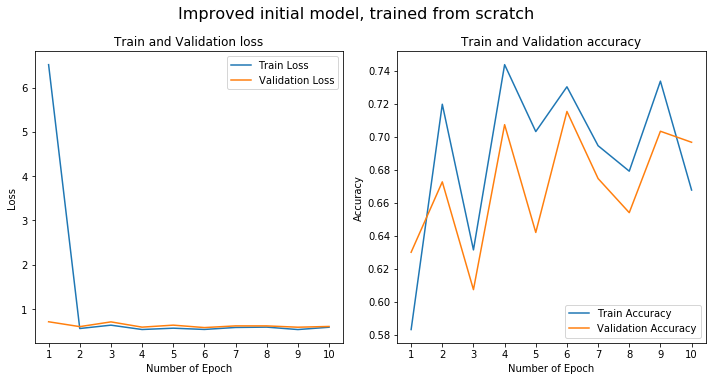

In [69]:
# YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Improved initial model, trained from scratch', fontsize = 16, y = 1.05)
fig.set_figheight(5)
fig.set_figwidth(10)
number_epoch=[i+1 for i in range(epoch+1)]
ax1.plot(number_epoch, train_avg_loss_3, label ='Train Loss')
ax1.plot(number_epoch, val_loss_3, label ='Validation Loss')
# naming the x axis 
ax1.set_xlabel('Number of Epoch') 
# naming the y axis 
ax1.set_ylabel('Loss') 
# giving a title to my graph 
ax1.set_title('Train and Validation loss') 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.legend()
ax2.plot(number_epoch, train_accuracy_3, label ='Train Accuracy')
ax2.plot(number_epoch, val_acc_3, label ='Validation Accuracy')
# naming the x axis 
ax2.set_xlabel('Number of Epoch') 
# naming the y axis 
ax2.set_ylabel('Accuracy') 
# giving a title to my graph 
ax2.set_title('Train and Validation accuracy') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend()
fig.tight_layout()

**(2 POE)** Did your results improve? What problems did your improvements fix? Explain why, or why not. 

**Your answer:** The initial model had a large overfitting problem which resulted in high training accuracy but fairly low validation accuracy. This problem has been solved with regularization, but the behaviour of the training is fluctuating a lot more for this model. We are now decreasing the learning rate when the validation accuracy hits 67% or higher, which may be the cause of this behaviour. We can still see that the curve of the accuracy is going upwards and the results for the 10th epoch are better in this model.   

[Save your model](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to disk (the architecture, weights and optimizer state). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual file you create is not relevant to your submission. The code to save the model is given in the cell below. 

In [61]:
# Assuming that you called your model 'model'
torch.save(model.state_dict(), 'model3')

---
## 4. Transfer Learning

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected layers + softmax). We'll substitute them with a single fully connected layer, and a classification layer that makes sense for our problem.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the *pretrained* VGG16 model, from the [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html).

In [16]:
vgg_model = torchvision.models.vgg16(pretrained=True, progress=True)

Create a new model with the layers you want to add on top of VGG.

*Hint:*
- You can access the top layers of the VGG model with `vgg_model.classifier`, and the remaining layers with `vgg_model.features`.
- You can get the number of output features of `vgg_model.features` with `vgg_model.classifier[0].in_features`

In [18]:
vgg_model.classifier = nn.Sequential(vgg_model.classifier[0])
vgg_model.classifier[0].in_features = 25088
vgg_model.classifier[0].out_features = 2
print(vgg_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=2, bias=True)
)


Now add the new model on top of VGG.

In [148]:
# Already solved in the box above

### 4.1 Using VGG features

Now we're almost ready to train the new model. However, since the top layers of this architecture are being initialized randomly, it's sometimes possible for them to generate large gradients that can wreck the pretraining of the bottom layers. To avoid this, freeze all the VGG layers in your architecture (i.e. signal to the optimizer that these should not be changed during optimization) by setting the attribute `requires_grad` for all parameters `vgg_model.features` to `False`.

In [149]:
# Freeze bottom
for param in vgg_model.features.parameters():
    param.requires_grad = False

Perform the transfer learning by training the top layers of your model.

In [12]:
''' Change size to 224x224 and set up the datasets accordingly '''
transformFunc = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

small_train = torchvision.datasets.ImageFolder(small_train_path, transform = transformFunc)
small_val = torchvision.datasets.ImageFolder(small_val_path, transform = transformFunc)

small_train_data_loader = DataLoader(small_train, batch_size=64, shuffle=True)
small_val_data_loader = DataLoader(small_val, batch_size=64)

In [151]:
# Train only the upper layer of the network 
vgg_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.classifier.parameters(), lr=0.01, weight_decay=0.01)

train_accuracy_4 =[]
train_avg_loss_4=[]
val_acc_4=[]
val_loss_4=[]

for epoch in range(10):
    losses = []
    n_correct = 0
    
    print('------ Epoch {} ------'.format(epoch+1))
    for i, (b_x, b_y) in enumerate(small_train_data_loader):
        
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        # Compute predictions and losses
        pred = vgg_model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        #if val_accuracy >= 0.70:
        #    optimizer = optim.Adam(vgg_model.parameters(), lr=0.0005, weight_decay=0.01) 
        
        # Count number of correct predictions
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
        if i % 10 == 0:
            print('Number of batches: {}'.format(i))
        
    # Compute accuracy and loss in the entire training set
    train_accuracy_4.append((n_correct/len(small_train)))
    train_avg_loss_4.append((sum(losses)/len(losses)))
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model(small_val_data_loader, vgg_model, loss_fn)
    
    val_acc_4.append((val_accuracy))
    val_loss_4.append((val_avg_loss))
        
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.5f} '
    display_str += '\tLoss (val): {:.5f}'
    display_str += '\tAccuracy: {:.5f} '
    display_str += '\tAccuracy (val): {:.5f}'
    print(display_str.format(epoch+1, train_avg_loss_4[epoch], val_loss_4[epoch], train_accuracy_4[epoch], val_acc_4[epoch]))

------ Epoch 1 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 1 	Loss: 1.19100 	Loss (val): 0.72460	Accuracy: 0.94343 	Accuracy (val): 0.97800
------ Epoch 2 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 2 	Loss: 0.12511 	Loss (val): 0.67715	Accuracy: 0.99314 	Accuracy (val): 0.97933
------ Epoch 3 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 3 	Loss: 0.08078 	Loss (val): 0.60143	Accuracy: 0.99543 	Accuracy (val): 0.98267
------ Epoch 4 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 4 	Loss: 0.04819 	Loss (val): 0.75204	Accuracy: 0.99600 	Accuracy (val): 0.98067
------ Epoch 5 ------
Number of batches:

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

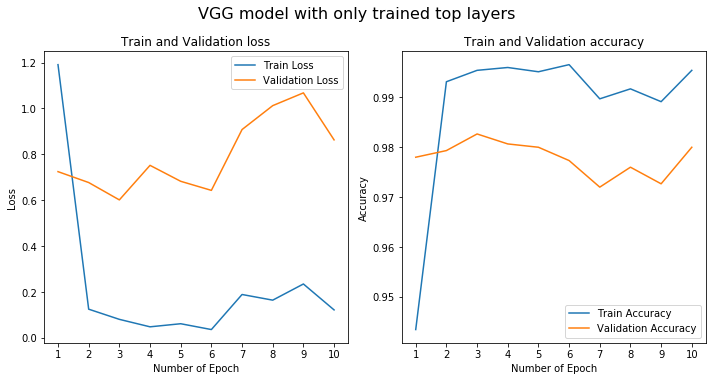

In [153]:
# YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('VGG model with only trained top layers', fontsize = 16, y = 1.05)
fig.set_figheight(5)
fig.set_figwidth(10)
number_epoch=[i+1 for i in range(epoch+1)]
ax1.plot(number_epoch, train_avg_loss_4, label ='Train Loss')
ax1.plot(number_epoch, val_loss_4, label ='Validation Loss')
# naming the x axis 
ax1.set_xlabel('Number of Epoch') 
# naming the y axis 
ax1.set_ylabel('Loss') 
# giving a title to my graph 
ax1.set_title('Train and Validation loss') 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.legend()
ax2.plot(number_epoch, train_accuracy_4, label ='Train Accuracy')
ax2.plot(number_epoch, val_acc_4, label ='Validation Accuracy')
# naming the x axis 
ax2.set_xlabel('Number of Epoch') 
# naming the y axis 
ax2.set_ylabel('Accuracy') 
# giving a title to my graph 
ax2.set_title('Train and Validation accuracy') 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend()
fig.tight_layout()

How does the model perform, compared to the model obtained in step 3? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

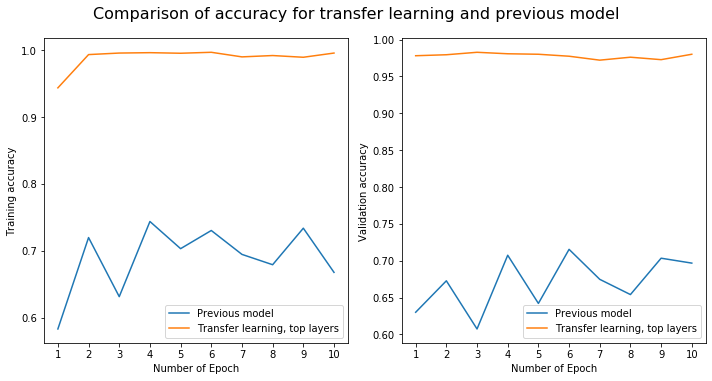

In [154]:
# YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison of accuracy for transfer learning and previous model', fontsize = 16, y = 1.05)
fig.set_figheight(5)
fig.set_figwidth(10)
number_epoch=[i+1 for i in range(epoch+1)]
ax1.plot(number_epoch, train_accuracy_3, label ='Previous model')
ax1.plot(number_epoch, train_accuracy_4, label ='Transfer learning, top layers')
# naming the x axis 
ax1.set_xlabel('Number of Epoch') 
# naming the y axis 
ax1.set_ylabel('Training accuracy') 
# giving a title to my graph 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.legend()
ax2.plot(number_epoch, val_acc_3, label ='Previous model')
ax2.plot(number_epoch, val_acc_4, label ='Transfer learning, top layers')
# naming the x axis 
ax2.set_xlabel('Number of Epoch') 
# naming the y axis 
ax2.set_ylabel('Validation accuracy') 
# giving a title to my graph 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend()
fig.tight_layout()

**(1 POE)** Compare these results. Which approach worked best, starting from scratch or doing transfer learning? Explain how you evaluated this.

**Your answer:** The transfer learning clearly performs better when comparing the accuracy of the validation. We can simply evaluate this from the plots above where the accuracy for validation is significantly better than the previous model. 

**(1 POE)** What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer:** The main difference is that the ImageNet dataset has 1000 image classifications and the Dogs vs Cats only has 2 separate image classifications. Another important difference is that the ImageNet has millions of images while the Dogs vs Cats dataset is restricted to 25 000 images

**Optional (2 POE)** Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer:** Since the VGG16 model is trained on the ImageNet dataset which contains 1000 image classifications (including dogs and cats) it is able to detect some of the input space features of the Dogs and Cats dataset which we are looking for. Therefore just changing the top layers of the VGG16 model to adapt to our dataset, which is a two classification problem, we get good results using this transfer learning technique.

**Optional (1 POE)** In which scenario would transfer learning be unsuitable?

**Your answer:** If the pretrained model don't include any similar features for the dataset of our interest, then transfer learning would give bad results. For an example if we use transfer learning on a dataset containing mushrooms and try to use that knowledge for classifying animals, we obviously won't gain much new information regarding the features of animals. 

Save the model to a file.

In [76]:
# Save the model: 
torch.save(vgg_model.state_dict(), 'trained_wo_finetune')

### 4.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers by resetting the `requires_grad` attribute to `True`.

In [156]:
# UnFreeze bottom
for param in vgg_model.features.parameters():
    param.requires_grad = True

Fine tune the model by training all the layers.

Hint:
- Even though we do have a decent starting point for the optimization, it's still possible that a bad hyper-parameter choice wrecks the preinitialization. Make sure to use a small learning rate for this step.

In [157]:
# Finetune train all the layers 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.0001, weight_decay=0.01)

train_accuracy_4ft=[]
train_avg_loss_4ft=[]
val_acc_4ft=[]
val_loss_4ft=[]

val_accuracy = 0

for epoch in range(10):
    losses = []
    n_correct = 0
    
    print('------ Epoch {} ------'.format(epoch+1))
    for i, (b_x, b_y) in enumerate(small_train_data_loader):
        
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        # Compute predictions and losses
        pred = vgg_model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        #if val_accuracy >= 0.70:
        #    optimizer = optim.Adam(vgg_model.parameters(), lr=0.0005, weight_decay=0.01) 
        
        # Count number of correct predictions
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
        if i % 10 == 0:
            print('Number of batches: {}'.format(i))
        
    # Compute accuracy and loss in the entire training set
    train_accuracy_4ft.append((n_correct/len(small_train)))
    train_avg_loss_4ft.append((sum(losses)/len(losses)))
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model(small_val_data_loader, vgg_model, loss_fn)
    
    val_acc_4ft.append((val_accuracy))
    val_loss_4ft.append((val_avg_loss))
        
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.5f} '
    display_str += '\tLoss (val): {:.5f}'
    display_str += '\tAccuracy: {:.5f} '
    display_str += '\tAccuracy (val): {:.5f}'
    print(display_str.format(epoch, train_avg_loss_4ft[epoch], val_loss_4ft[epoch], train_accuracy_4ft[epoch], val_acc_4ft[epoch]))

------ Epoch 1 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 0 	Loss: 0.33337 	Loss (val): 0.58733	Accuracy: 0.97343 	Accuracy (val): 0.96600
------ Epoch 2 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 1 	Loss: 0.08200 	Loss (val): 0.17910	Accuracy: 0.99029 	Accuracy (val): 0.98000
------ Epoch 3 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 2 	Loss: 0.02092 	Loss (val): 0.18490	Accuracy: 0.99686 	Accuracy (val): 0.97800
------ Epoch 4 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 3 	Loss: 0.00997 	Loss (val): 0.19048	Accuracy: 0.99771 	Accuracy (val): 0.98533
------ Epoch 5 ------
Number of batches:

How does the model perform, compared to the model trained with freezed layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

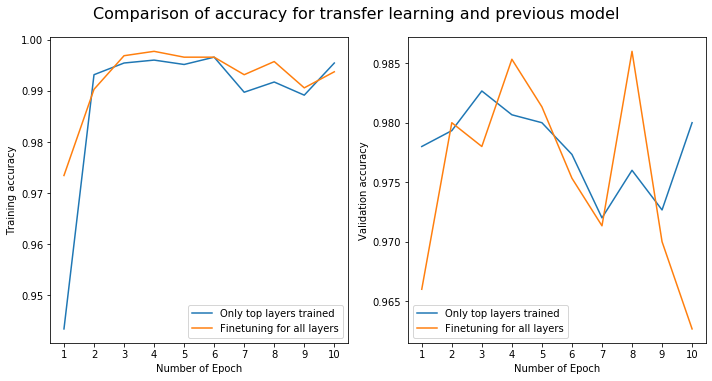

In [158]:
# YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison of accuracy for transfer learning and previous model', fontsize = 16, y = 1.05)
fig.set_figheight(5)
fig.set_figwidth(10)
number_epoch=[i+1 for i in range(epoch+1)]
ax1.plot(number_epoch, train_accuracy_4, label ='Only top layers trained')
ax1.plot(number_epoch, train_accuracy_4ft, label ='Finetuning for all layers')
# naming the x axis 
ax1.set_xlabel('Number of Epoch') 
# naming the y axis 
ax1.set_ylabel('Training accuracy') 
# giving a title to my graph 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.legend()
ax2.plot(number_epoch, val_acc_4, label ='Only top layers trained')
ax2.plot(number_epoch, val_acc_4ft, label ='Finetuning for all layers')
# naming the x axis 
ax2.set_xlabel('Number of Epoch') 
# naming the y axis 
ax2.set_ylabel('Validation accuracy') 
# giving a title to my graph 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend()
fig.tight_layout()

**(1 POE)** Did the model's performance improve? Why (why not)?

**Your answer:** The performance is about the same for both models. This may be due to the VGG16 model being pretrained sufficiently already on these features. Another reason may be due to the very low learning rate (lr = 0.0001) which were used for the finetuning. As a conclusion, we can see that the performance is not degrading in time comparing to the previous model, however the last two epochs gives in comparison bad results. The results would most probably be even better by finetuning the layers for more epochs with decaying learning rate such that the accuracy becomes more stable. 

Save the model to file.

In [159]:
torch.save(vgg_model.state_dict(), 'trans_learning_full')

### 4.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here.

In [98]:
improved_vgg_model = torchvision.models.vgg16(pretrained=True, progress=True)

In [100]:
improved_vgg_model.classifier[6].out_features = 2

In [102]:
# Freeze bottom
for param in improved_vgg_model.features.parameters():
    param.requires_grad = False

In [103]:
# Train only the upper layer of the network 
improved_vgg_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_vgg_model.classifier.parameters(), lr=0.01, weight_decay=0.01)

train_accuracy =[]
train_avg_loss=[]
val_acc=[]
val_loss=[]

val_accuracy = 0

for epoch in range(10):
    losses = []
    n_correct = 0
    
    print('------ Epoch {} ------'.format(epoch+1))
    for i, (b_x, b_y) in enumerate(small_train_data_loader):
        
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        # Compute predictions and losses
        pred = improved_vgg_model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        #if val_accuracy >= 0.70:
        #    optimizer = optim.Adam(vgg_model.parameters(), lr=0.0005, weight_decay=0.01) 
        
        # Count number of correct predictions
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
        if i % 10 == 0:
            print('Number of batches: {}'.format(i))
        
    # Compute accuracy and loss in the entire training set
    train_accuracy.append((n_correct/len(small_train)))
    train_avg_loss.append((sum(losses)/len(losses)))
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model(small_val_data_loader, improved_vgg_model, loss_fn)
    
    val_acc.append((val_accuracy))
    val_loss.append((val_avg_loss))
        
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.5f} '
    display_str += '\tLoss (val): {:.5f}'
    display_str += '\tAccuracy: {:.5f} '
    display_str += '\tAccuracy (val): {:.5f}'
    print(display_str.format(epoch+1, train_avg_loss[epoch], val_loss[epoch], train_accuracy[epoch], val_acc[epoch]))

------ Epoch 1 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 1 	Loss: 184.45971 	Loss (val): 20.22364	Accuracy: 0.87371 	Accuracy (val): 0.93333
------ Epoch 2 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 2 	Loss: 17.66453 	Loss (val): 25.13881	Accuracy: 0.96857 	Accuracy (val): 0.97000
------ Epoch 3 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 3 	Loss: 18.21511 	Loss (val): 39.40450	Accuracy: 0.97629 	Accuracy (val): 0.96200
------ Epoch 4 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 4 	Loss: 9.66621 	Loss (val): 52.09633	Accuracy: 0.98371 	Accuracy (val): 0.96867
------ Epoch 5 ------
Number of 

In [105]:
# UnFreeze bottom
for param in improved_vgg_model.features.parameters():
    param.requires_grad = True

In [106]:
# Finetune train all the layers 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_vgg_model.parameters(), lr=0.0001, weight_decay=0.01)

train_accuracy_best=[]
train_avg_loss_best=[]
val_acc_best=[]
val_loss_best=[]

val_accuracy = 0

for epoch in range(10):
    losses = []
    n_correct = 0
    
    print('------ Epoch {} ------'.format(epoch+1))
    for i, (b_x, b_y) in enumerate(small_train_data_loader):
        
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        # Compute predictions and losses
        pred = improved_vgg_model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        #if val_accuracy >= 0.70:
        #    optimizer = optim.Adam(vgg_model.parameters(), lr=0.0005, weight_decay=0.01) 
        
        # Count number of correct predictions
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
        if i % 10 == 0:
            print('Number of batches: {}'.format(i))
        
    # Compute accuracy and loss in the entire training set
    train_accuracy_best.append((n_correct/len(small_train)))
    train_avg_loss_best.append((sum(losses)/len(losses)))
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model(small_val_data_loader, improved_vgg_model, loss_fn)
    
    val_acc_best.append((val_accuracy))
    val_loss_best.append((val_avg_loss))
        
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.5f} '
    display_str += '\tLoss (val): {:.5f}'
    display_str += '\tAccuracy: {:.5f} '
    display_str += '\tAccuracy (val): {:.5f}'
    print(display_str.format(epoch+1, train_avg_loss_best[epoch], val_loss_best[epoch], train_accuracy_best[epoch], val_acc_best[epoch]))

------ Epoch 1 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 1 	Loss: 65.62604 	Loss (val): 35.67779	Accuracy: 0.95857 	Accuracy (val): 0.95933
------ Epoch 2 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 2 	Loss: 4.15704 	Loss (val): 26.07140	Accuracy: 0.98657 	Accuracy (val): 0.97000
------ Epoch 3 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 3 	Loss: 2.47455 	Loss (val): 27.08315	Accuracy: 0.98771 	Accuracy (val): 0.95800
------ Epoch 4 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Epoch 4 	Loss: 1.82485 	Loss (val): 20.10237	Accuracy: 0.98886 	Accuracy (val): 0.97200
------ Epoch 5 ------
Number of bat

**(1 POE)** How does the model perform, compared to the model trained in step 4.2? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

**Answer:** The difference between the two models is that the improved one uses the same architecture for the classifier as VGG16 but the last FC layer has an output of 2. The results in the plots show that the new model is  performing slightly better than the previous model for the last epoch. 

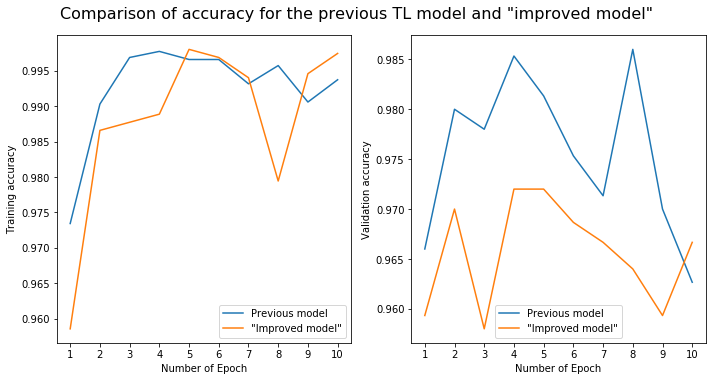

In [160]:
# YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison of accuracy for the previous TL model and improved model', fontsize = 16, y = 1.05)
fig.set_figheight(5)
fig.set_figwidth(10)
number_epoch=[i+1 for i in range(epoch+1)]
ax1.plot(number_epoch, train_accuracy_4ft, label ='Previous model')
ax1.plot(number_epoch, train_accuracy_best, label ='"Improved model"')
# naming the x axis 
ax1.set_xlabel('Number of Epoch') 
# naming the y axis 
ax1.set_ylabel('Training accuracy') 
# giving a title to my graph 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.legend()
ax2.plot(number_epoch, val_acc_4ft, label ='Previous model')
ax2.plot(number_epoch, val_acc_best, label ='"Improved model"')
# naming the x axis 
ax2.set_xlabel('Number of Epoch') 
# naming the y axis 
ax2.set_ylabel('Validation accuracy') 
# giving a title to my graph 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend()
fig.tight_layout()

Save the model to a file.

In [111]:
torch.save(improved_vgg_model.state_dict(), 'not_the_best_trans_learning')

## 5. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data generators, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [162]:
''' Make a compose transform function to be used in ImageFolder, this both resizes and converts to type tensor '''
transformFunc = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train = torchvision.datasets.ImageFolder(train_path, transform = transformFunc)
val = torchvision.datasets.ImageFolder(val_path, transform = transformFunc)

train_data_loader = DataLoader(train, batch_size=64, shuffle=True)
val_data_loader = DataLoader(val, batch_size=64)

In [163]:
def evaluate_model_final(val_data_loader, model, loss_fn):
    losses = []
    n_correct = 0
    with torch.no_grad():
        for b_x, b_y in val_data_loader:            
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()
        val_accuracy = n_correct/len(val)
        val_avg_loss = sum(losses)/len(losses)    

    return val_accuracy, val_avg_loss

Train your model using the full data. This optimization might take a long time, so live plotting of some metrics is recommended.

In [164]:
best_model = improved_vgg_model

In [165]:
# Train all the layers for the previous best model with the full data set  
best_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.classifier.parameters(), lr=0.001, weight_decay=0.01)

train_accuracy_final =[]
train_avg_loss_final=[]
val_acc_final=[]
val_loss_final=[]

for epoch in range(10):
    losses = []
    n_correct = 0
    
    print('------ Epoch {} ------'.format(epoch+1))
    for i, (b_x, b_y) in enumerate(train_data_loader):
        
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        # Compute predictions and losses
        pred = best_model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        #if val_accuracy >= 0.70:
        #    optimizer = optim.Adam(vgg_model.parameters(), lr=0.0005, weight_decay=0.01) 
        
        # Count number of correct predictions
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
        if i % 10 == 0:
            print('Number of batches: {}'.format(i))
        
    # Compute accuracy and loss in the entire training set
    train_accuracy_final.append((n_correct/len(train)))
    train_avg_loss_final.append((sum(losses)/len(losses)))
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model_final(val_data_loader, best_model, loss_fn)
    
    val_acc_final.append((val_accuracy))
    val_loss_final.append((val_avg_loss))
        
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.5f} '
    display_str += '\tLoss (val): {:.5f}'
    display_str += '\tAccuracy: {:.5f} '
    display_str += '\tAccuracy (val): {:.5f}'
    print(display_str.format(epoch+1, train_avg_loss_final[epoch], val_loss_final[epoch], train_accuracy_final[epoch], val_acc_final[epoch]))

------ Epoch 1 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Number of batches: 60
Number of batches: 70
Number of batches: 80
Number of batches: 90
Number of batches: 100
Number of batches: 110
Number of batches: 120
Number of batches: 130
Number of batches: 140
Number of batches: 150
Number of batches: 160
Number of batches: 170
Number of batches: 180
Number of batches: 190
Number of batches: 200
Number of batches: 210
Number of batches: 220
Number of batches: 230
Number of batches: 240
Number of batches: 250
Number of batches: 260
Number of batches: 270
Epoch 1 	Loss: 1.98325 	Loss (val): 0.76796	Accuracy: 0.96429 	Accuracy (val): 0.96947
------ Epoch 2 ------
Number of batches: 0
Number of batches: 10
Number of batches: 20
Number of batches: 30
Number of batches: 40
Number of batches: 50
Number of batches: 60
Number of batches: 70
Number of batches: 80
Number of batches: 90
Number of batches

In [166]:
# YOUR CODE HERE
torch.save(best_model.state_dict(), 'final_trans_learning')

How does the model perform now when trained on the entire dataset, compared to when only trained on the smaller subset of data? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

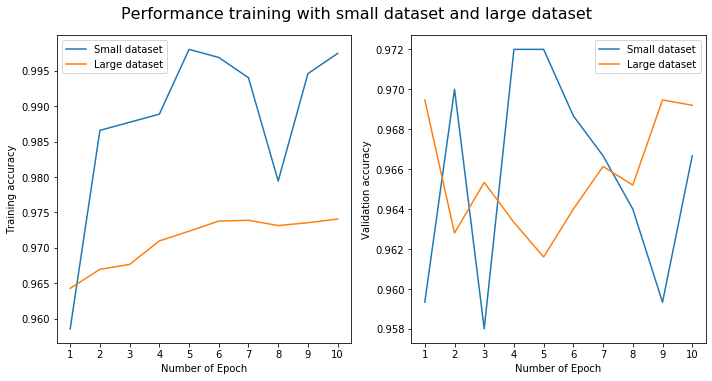

In [168]:
# YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Performance training with small dataset and large dataset', fontsize = 16, y = 1.05)
fig.set_figheight(5)
fig.set_figwidth(10)
number_epoch=[i+1 for i in range(epoch+1)]
ax1.plot(number_epoch, train_accuracy_best, label ='Small dataset')
ax1.plot(number_epoch, train_accuracy_final, label ='Large dataset')
# naming the x axis 
ax1.set_xlabel('Number of Epoch') 
# naming the y axis 
ax1.set_ylabel('Training accuracy') 
# giving a title to my graph 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.legend()
ax2.plot(number_epoch, val_acc_best, label ='Small dataset')
ax2.plot(number_epoch, val_acc_final, label ='Large dataset')
# naming the x axis 
ax2.set_xlabel('Number of Epoch') 
# naming the y axis 
ax2.set_ylabel('Validation accuracy') 
# giving a title to my graph 
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend()
fig.tight_layout()

**(2 POE)** What can you conclude from these plots?

**Your answer:** The training accuracy and the validation accuracy for the large dataset are more similar to each other which implies we have less overfitting than the model with small dataset. We achieve similar results regarding the accuracies of both models, but since we are using a larger dataset the validation accuracy for this model is more trustworthy.

## 6. Evaluation on test set

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labeled, so we can't compute any performance metrics ourselves. Instead, we'll create a .csv file containing the predictions for each sample, and submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

Hints:
- There is a sample_submission file available for download in the same place where you downloaded the data from. Take a look at it to better understand what is the expected format here.
- The Python module `os` has a `listdir` function, which returns the filenames of all files in a given path.
- If you don't know how to create and write to files with Python, Google can help.

In [260]:
vgg_model = torchvision.models.vgg16(pretrained=False, progress=True)

In [261]:
best_model = vgg_model
best_model.classifier[6].out_features = 2
best_model.load_state_dict(torch.load('/workspace/home-assignments/HA1/final_trans_learning'))
best_model.eval()
best_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [262]:
# Load the images from the test folder and transform them
test_path = '/workspace/home-assignments/HA1/test_folder'

transformFunc = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transformFunc)

test_data_loader = DataLoader(test_dataset, batch_size = 1)

In [263]:
# Save all the ids in a list
ids = []

for i in range(len(test_data_loader)):
    string = test_dataset.samples[i][0]
    start = string.find('test/') + 5
    end = string.find('.jpg', start)
    ids.append(string[start:end])

In [295]:
# Make a function to check all images and classify each into a list
import numpy as np

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def test_check(test_data_loader, model):
    pred = []
    for i, (image, labels) in enumerate(test_data_loader): 
        image = image.to(device)
        pred_tensor = model(image)
        pred_vek = (pred_tensor[0][0].item(), pred_tensor[0][1].item())
        softmax_vek = softmax((pred_vek))
        pred.append(softmax_vek[1])

        if i % 1000 == 0:
            print(i)
    return pred

In [296]:
# Run through the model and get all prediction labels
labels = test_check(test_data_loader, best_model)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [312]:
# Stack the ids and vector together
ids_int = list(map(int, ids))
labels_float = list(map(float, labels))
#submission = np.column_stack((list(map(int, ids)), list(map(int, labels))))
#submission_sorted = submission[submission[:,0].argsort()]

In [323]:
# Make a dataframe object containing both the ids and labels
submission = list(zip(ids_int,labels_float))
predictions = pd.DataFrame(submission, columns = ['id','label'], index = None)

In [300]:
# Save as .csv file from the dataframe object
import pandas as pd
pd.DataFrame(predictions).to_csv('/workspace/home-assignments/HA1/predictions.csv', header = True, index = None)

In [325]:
predictions.to_csv(r'/workspace/home-assignments/HA1/predictions.csv', index = None)

**(2 POE)** Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, so submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). Kaggle evaluates your submission according to your log-loss score. Which score did you obtain?

**Your answer:** 0.14082

What was the username you used for this submission?

**Your answer:** jmartins11